This notebook is a set of different test for checking a strategy and check it in all the possible scenarios set by parameter:
1) Create / backtest strategies for a specific strategy and compare with naive buy & hold strategy
2) Extract statistics to see the probability of some scenarios

Here the strategy: https://www.tradingview.com/script/V2cjsLhI-Volume-Bar-Breakout-and-Breakdown-Indicator/

#### Imports

In [1]:
from scipy.optimize import brute
from binance.client import Client
import pandas as pd
import numpy as np
from datetime import datetime
from typing import Optional
import configparser


# Read local file `config.ini`.
config = configparser.ConfigParser()
config.read('../settings/api_ks.ini')

coin="BTCUSDT"
# These API keys are not valid, just a couple of examples. You need to go: https://www.binance.com/en/my/settings/api-management in your binance account and set your API keys.
api_key = config['BINANCE']['API_KEY']
api_secret_key = config['BINANCE']['API_SECRET_KEY']
client = Client(api_key, api_secret_key)

#### Some helper functions and creation of Backtester class

In [2]:
def set_pandas_display_options() -> None:
    """Set pandas display options."""
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = 1000
    # display.precision = 2  # set as needed

set_pandas_display_options()

In [3]:
class ToolboxPriceAnalytics(object):
    @staticmethod
    def dataframe_from_historicalklines(data_klines: list)-> pd.DataFrame:
        """Get data list from get_historical_Klines and creates a Dataframe.

        Args:
            data_klines (list): A list of candles obtained using get_historical_Klines

        Returns:
            pd.DataFrame: A dataframe containing these columns
            ["time", "open", "high", "low", "close", "volume", "close_time", "qav", "ntrades", "tbav", "tbqav", "ignore"]
        """
        data = pd.DataFrame(data_klines, columns=["time", "open", "high", "low", "close", "volume", "close_time", "qav", "ntrades", "tbav", "tbqav", "ignore"])
        data = data.apply(pd.to_numeric)
        # Cleaning the columns that won't be needed
        data.drop("close_time", inplace=True, axis=1)
        data.drop("qav", inplace=True, axis=1)
        data.drop("tbav", inplace=True, axis=1)
        data.drop("tbqav", inplace=True, axis=1)
        data.drop("ignore", inplace=True, axis=1)
        return data
       
    @staticmethod
    def study_max_delta(data: pd.DataFrame, windows: int)->pd.DataFrame:
        """Includes in the dataframe (data) 4 columns per windows, calculating: 
        1) close_w_<#window>               :  close price in # window ahead
        2) close_delta_w_<#window>         :  delta between the current price and the same we will find in <#window> ahead
        3) close_delta_w_per_<#window>     :  delta in percentage
        4) close_low_consecutive_<#window> :  1 when all the previous candels delta where bellow the threshold

        Args:
            data (pd.DataFrame): A dataframe prepared with, at least, dataframe_from_historicalKlines columns
            windows (int): Number of windows that will be calculated

        Returns:
            pd.DataFrame: [description]
        """
        assert data.empty == False
        assert windows > 0
        for i in range(1, windows+1):
            data['close_next_cdl_'+str(i)]               = data['close'].shift(-i)
            data.fillna(0, inplace=True)
            data['close_delta_next_cdl_'+str(i)]         = data['close_next_cdl_'+str(i)]-data['close']
            data['close_delta_next_cdl_pert_'+str(i)]    = (data['close_next_cdl_'+str(i)]-data['close'])/data['close']*100
            #data['close_low_consecutive_'+str(i)] = np.where(data[])
        return data

In [4]:
class HVRJBacktester2(object):
    """ Class for the vectorized backtesting of SMA-based trading strategies.
    """
    def __init__(self, 
                 data: pd.DataFrame, 
                 price_column: str , 
                 window_size: int, 
                 start: datetime = None, 
                 end: datetime = None, 
                 lookback: int = 75):

        # initialize the object
        assert data is not None
        self.window_size: int = window_size
        self.data: pd.Dataframe = data
        self.price_column: str = price_column
        self.start: Optional[datetime] = start
        self.end: Optional[datetime] = end
        self.results = None
        self.strategies: set = set()
        self.lookback: int = lookback
        
        # naive strategy is needed to be calculated only once
        self.set_strategy_parameters(1)

        if self.window_size != 1:
            self.set_strategy_parameters(window_size)
        self.strategy_return = 0
        #assert self.start < self.end
        
    @staticmethod
    def prepare_data(data_klines: list, lookback: int = 75)-> pd.DataFrame:
        """Will prepare a dataframe from to be used with the strategy Range High Volume 

        Args:
            data_klines: list A list created from get_historical_klines
            lookback: (int, optional) Number of candles that will be use for the calculus of highVolume and lowVolume and the BO and BD. Defaults to 75.

        Returns:
            pd.DataFrame: a Dataframe containing all the data needed for being used with the class HRVJ_Backtesters 
        """
        lookback = lookback
    
        def column_from_series(s: pd.Series, column: str):
            hvb = data.loc[s.idxmax(), column]
            return hvb
        
        # Create the dataframe from the list containing the raw data
        data = ToolboxPriceAnalytics.dataframe_from_historicalklines(data_klines)
        
        # Calculate all the columns that will be needed
        data["highVB"] = data.volume.rolling(lookback).apply(column_from_series,  kwargs={'column':"high"}, raw=False)
        data["lowVB"] = data.volume.rolling(lookback).apply(column_from_series,  kwargs={'column':"low"}, raw=False)
        data["volMA"] = data.volume.rolling(20).mean()
        data["volNext"] = data.volume.shift(1)
        data["cloNext"] = data.close.shift(1)
        data["overMidBar"] = (data.close-data.low)/(data.high-data.low) > 0.5
        data["underMidBar"] = (data.close-data.low)/(data.high-data.low) < 0.5
        data["breakout"] = np.where((data.cloNext<data.highVB) & (data.close>data.highVB) & (data.volume>data.volMA)  & data.overMidBar, 1, 0)
        data["breakdown"] = np.where((data.cloNext>data.lowVB) & (data.close<data.lowVB) & (data.volume>data.volMA)  & data.underMidBar, 1, 0)
        
        data["time"] = data["time"].astype(str).apply(lambda tm: datetime.fromtimestamp(int(tm[:-3])))
        data.set_index("time", inplace=True)
        
        return data.fillna(0)
        
    def set_strategy_parameters(self, window_size: int) -> tuple:
        """Set all the parameters for the strategy: Volume Bar Breakout / Breakdown: 
        https://www.tradingview.com/script/V2cjsLhI-Volume-Bar-Breakout-and-Breakdown-Indicator/ 
        
        This class is an excuse for creating and testing a class where we are using a non-trivial strategy and how we can check the 
        strategy using a brute-force test.
        
        Note:
        The low volume of data allow me to include all the data in each row for easy testing, so instead of doing df.diff(), I'll store the
        columns and then substract it.

        Args:
            window_size (int): Size of the window (in candles) for testing te strategy.

        Returns:
            tuple: check run_strategy 
        """
        assert self.window_size > 0
        self.window_size = window_size
        
        if window_size not in self.strategies:
            self.strategies.add(window_size)
        else:
            return self.run_strategy()
        
        str_window_size = str(window_size)
        
        self.data['current_window'] = self.window_size
        self.data["cloFuture_"+str_window_size] = self.data.close.shift(-window_size)
        self.data["volFuture_"+str_window_size] = self.data.volume.shift(-window_size)

        # Storing the fail history
        self.data["fail_"+str_window_size] = 0
        self.data["fail_bo_"+str_window_size] = 0
        self.data["fail_bd_"+str_window_size] = 0
        self.data["fail_bo_"+str_window_size] = np.where((self.data.breakout==1) & (self.data.close > self.data["cloFuture_"+str_window_size]),
                                                           self.data["fail_"+str_window_size]+1,
                                                           self.data["fail_"+str_window_size])
        self.data["fail_bd_"+str_window_size] = np.where((self.data.breakdown==1) & (self.data.close < self.data["cloFuture_"+str_window_size]),
                                                           self.data["fail_"+str_window_size]+1,
                                                           self.data["fail_"+str_window_size])
        self.data["fail_"+str_window_size] = self.data["fail_bo_"+str_window_size]+self.data["fail_bd_"+str_window_size]
        
        # Storing the success
        self.data["succ_"+str_window_size] = 0
        self.data["succ_bo_"+str_window_size] = 0
        self.data["succ_bd_"+str_window_size] = 0
        self.data["succ_bo_"+str_window_size] = np.where(
            self.data.breakout & (self.data.close < self.data["cloFuture_" + str_window_size]),
            self.data["succ_"+str_window_size] + 1,
            self.data["succ_"+str_window_size])
        self.data["succ_bd_"+str_window_size] = np.where(
            self.data.breakdown & (self.data.close > self.data["cloFuture_" + str_window_size]),
            self.data["succ_"+str_window_size] + 1,
            self.data["succ_"+str_window_size])
        self.data["succ_"+str_window_size] = self.data["succ_bo_"+str_window_size]+self.data["succ_bd_"+str_window_size]
        
        # Storing the accumulate fail and success in price and percentage
        self.data["close_fail_bo_"+str_window_size] = np.where(self.data["fail_bo_"+str_window_size], 
                                                        self.data.breakout*(self.data["cloFuture_"+str_window_size]-self.data.close),
                                                        0)
        # We represent the fails with negative numbers, so when we have a close_succ_db even though the future_close-initial_close is positive, 
        # the loss needs to be presented with a negative (becasue we are in a sell)
        self.data["close_fail_bd_"+str_window_size] = np.where(self.data["fail_bd_"+str_window_size], 
                                                        -self.data.breakdown*(self.data["cloFuture_"+str_window_size]-self.data.close),
                                                        0)
        self.data["close_fail_"+str_window_size] =  self.data["close_fail_bo_"+str_window_size] + self.data["close_fail_bd_"+str_window_size]
    
        # this will be positive as needs to be presented in a successful breakout
        self.data["close_succ_bo_"+str_window_size] = np.where(self.data["succ_"+str_window_size],
                                                       self.data.breakout*(self.data["cloFuture_"+str_window_size]-self.data.close),
                                                       0)
        # this will be -1*X so positive as needs to be presented in a succcessful breakdown
        self.data["close_succ_bd_"+str_window_size] = np.where(self.data["succ_"+str_window_size],
                                                       -self.data.breakdown*(self.data["cloFuture_"+str_window_size]-self.data.close),
                                                       0)
        # this will be a positive number (or 0)
        self.data["close_succ_"+str_window_size] = self.data["close_succ_bo_"+str_window_size] + self.data["close_succ_bd_"+str_window_size]
        
        # The total strategy is to follow every single bo and bd
        self.data['total_return_strategy_'+str_window_size] = self.data['close_succ_'+str_window_size].cumsum() + self.data['close_fail_'+str_window_size].cumsum()
        
        # base case
        if window_size==1:
            # Buy and Hold is begining - final price, always
            self.data['naivestrategy'] = self.data.iloc[-1]['close']-self.data.iloc[0]['close']
        
        # return for this windows size without strategy
        self.data['no_strategy_return_'+str_window_size] = (self.data[self.price_column].shift(-self.window_size) - self.data[self.price_column] ) / self.data[self.price_column]
        self.data.fillna(0, inplace=True)
        self.run_strategy()

    def run_strategy(self)-> tuple:
        """
        Backtests the trading strategy.
        returns: (performance_strategy, performance_strategy - naive)
        """
        str_ws = str(self.window_size)
        # gross performance of the strategy
        aperf = self.data['total_return_strategy_'+str_ws].iloc[-1]
        # out-/underperformance of strategy
        operf = aperf - self.data['naivestrategy'].iloc[-1]
        self.strategy_return = (round(aperf, 10), round(operf, 10))
        return self.strategy_return

    # def plot_results(self):
    #     ''' Plots the cumulative performance of the trading strategy
    #     compared to the symbol.
    #     '''
    #     if self.results is None:
    #         print('No results to plot yet. Run a strategy.')
    #     title = '%s | SMA1=%d, SMA2=%d' % (self.symbol,
    #                                        self.SMA1, self.SMA2)
    #     self.results[['naivestrategy', 'cstrategy']].plot(title=title,
    #                                                       figsize=(10, 6))

    def update_and_run(self, parameter):
        """ Updates parameters and returns negative absolute performance (for minimization algorithm).
        returns negative performance of the strategy
        """
        self.set_strategy_parameters(parameter[0])
        res = -self.run_strategy()[0]
        return res

    def optimize_parameters(self, parameter_range):
        """ Finds global maximum given the SMA parameter ranges.
        Parameters: tuple
            tuples of the form (start, end, step size)
        """
        opt = brute(self.update_and_run, (parameter_range,), finish=None)
        return opt, -self.update_and_run((int(opt),))
    
    def describe_strategy(self, window_size:int, force:bool=False)->dict:
        """ Set the window_size and run the strategy for returning the results of the strategy in a human-readable way

        Args:
            window_size (int): number of candles that will use in this strategy
            force (bool, optional): force the set of the window_size in case it is not

        Returns:
            dict: A dictionary containing all the strategy results for the current window_size
        """
        if window_size not in self.strategies and force:
            self.set_strategy_parameters(window_size)
        elif window_size not in self.strategies and not force:
            return {}

        str_ws         = str(window_size)
        num_fails_bo   = self.data["fail_bo_"+str_ws].sum()
        num_fails_bd   = self.data["fail_bd_"+str_ws].sum()
        num_fails      = self.data["fail_"+str_ws].sum()
        num_succ_bo    = self.data["succ_bo_"+str_ws].sum()
        num_succ_bd    = self.data["succ_bd_"+str_ws].sum()
        num_succ       = self.data["succ_"+str_ws].sum()
        total_signals  = num_fails+num_succ
        perct_fail             = 0 if total_signals == 0 else num_fails/total_signals
        perct_fail_bo_vs_total = 0 if total_signals == 0 else num_fails_bo / total_signals
        perct_fail_bo_vs_bo    = 0 if (num_fails_bo+num_succ_bo) == 0 else num_fails_bo / (num_fails_bo+num_succ_bo)
        perct_fail_bd_vs_total = 0 if total_signals == 0 else num_fails_bd / total_signals
        perct_fail_bd_vs_bd    = 0 if (num_fails_bd+num_succ_bd) == 0 else num_fails_bd / (num_fails_bd+num_succ_bd)
        perct_succ     = 0 if total_signals == 0 else 1-perct_fail
        price_fails    = self.data["close_fail_"+str_ws].sum()
        price_succ     = self.data["close_succ_"+str_ws].sum()
        price_fails_bo = self.data["close_fail_bo_"+str_ws].sum()
        price_fails_bd = self.data["close_fail_bd_"+str_ws].sum()
        price_succ_bo  = self.data["close_succ_bo_"+str_ws].sum()
        price_succ_bd  = self.data["close_succ_bd_"+str_ws].sum()
        res = { 'window_size'          : window_size,
                'total_signals'        : total_signals,
                'total_bo_signals'     : self.data['breakout'].sum(),
                'total_db_signals'     : self.data['breakdown'].sum(),
                'num_fails'            : num_fails, 
                'num_succ'             : num_succ,
                'num_fails_bo'         : num_fails_bo,
                'num_succ_bo'          : num_succ_bo,
                'perct_fail_bo'        : perct_fail_bo_vs_total,
                'price_fails_bo'       : price_fails_bo,
                'price_succ_bo'        : price_succ_bo,
                'perct_fail_bo_vs_bo'  : perct_fail_bo_vs_bo,
                'num_fails_bd'         : num_fails_bd,
                'num_succ_bd'          : num_succ_bd,
                'price_succ_bd'        : price_succ_bd,
                'price_fails_bd'       : price_fails_bd,
                'perct_fail_bd'        : perct_fail_bd_vs_total,
                'perct_fail_bd_vs_bd'  : perct_fail_bd_vs_bd,
                'total_perct_fail'     : perct_fail, 
                'total_perct_succ'     : perct_succ, 
                'total_price_fail'    : price_fails, 
                'total_price_succ'     : price_succ, 
                'total_max_pain_radio' : self.data['total_return_strategy_'+str_ws].min(),
                'total_max_gain_radio' : self.data['total_return_strategy_'+str_ws].max(),
                'total_return_strategy': self.data["total_return_strategy_"+str_ws].iloc[-1],
                'total_return_naive'   : self.data["naivestrategy"].iloc[-1]}
        return res
    
    def describe_strategies(self, windows_sizes: list, force:bool=False)->pd.DataFrame:
        res = [self.describe_strategy(i,force) for i in windows_sizes ] 
        return pd.DataFrame(res)

 Study of the strategy for 1Hour interval in the last 6 days. 1st we get the data, then we prepare the data and, we run the strategy

In [5]:
data_1h_6d = client.get_historical_klines(coin, Client.KLINE_INTERVAL_1HOUR, "6 day ago UTC")
data_n = HVRJBacktester2.prepare_data(data_1h_6d.copy())

In [6]:
strateg = HVRJBacktester2(data_n.copy(), 'close', 1)
strateg.optimize_parameters((1,5,1))
strateg.describe_strategies(list(range(1,5)))

,window_size,total_signals,total_bo_signals,total_db_signals,num_fails,num_succ,num_fails_bo,num_succ_bo,perct_fail_bo,price_fails_bo,price_succ_bo,perct_fail_bo_vs_bo,num_fails_bd,num_succ_bd,price_succ_bd,price_fails_bd,perct_fail_bd,perct_fail_bd_vs_bd,total_perct_fail,total_perct_succ,total_price_fail,total_price_succ,total_max_pain_radio,total_max_gain_radio,total_return_strategy,total_return_naive
0,1,2,0,2,1,1,0,0,0.0,0.0,0.0,0,1,1,98.29,-140.65,0.5,0.5,0.5,0.5,-140.65,98.29,-140.65,0.0,-42.36,735.56
1,2,2,0,2,1,1,0,0,0.0,0.0,0.0,0,1,1,80.02,-90.32,0.5,0.5,0.5,0.5,-90.32,80.02,-90.32,0.0,-10.30,735.56
2,3,2,0,2,2,0,0,0,0.0,0.0,0.0,0,2,0,0.00,-291.67,1.0,1.0,1.0,0.0,-291.67,0.00,-291.67,0.0,-291.67,735.56
3,4,2,0,2,2,0,0,0,0.0,0.0,0.0,0,2,0,0.00,-210.50,1.0,1.0,1.0,0.0,-210.50,0.00,-210.50,0.0,-210.50,735.56


<AxesSubplot:title={'center':'return'}, xlabel='window_size'>

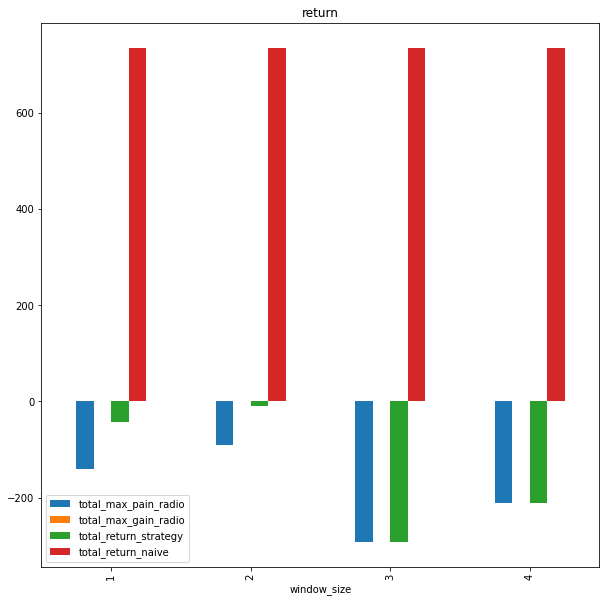

In [7]:
strateg.describe_strategies(list(range(1,5))).plot(kind='bar',
                                                   x='window_size', 
                                                       y=['total_max_pain_radio', 'total_max_gain_radio', 'total_return_strategy', 'total_return_naive'],
                                                       title="return",
                                                       figsize=(10,10))

# Study 1h interval

### In the last 365 days

In [8]:
data_1h_365d = client.get_historical_klines(coin, Client.KLINE_INTERVAL_1HOUR, "365 day ago UTC")
data_1h_365d = HVRJBacktester2.prepare_data(data_1h_365d.copy())

In [9]:
strateg = HVRJBacktester2(data_1h_365d.copy(), 'close', 1)
strateg.optimize_parameters((1,5,1))
strateg.describe_strategies(list(range(1,5)))

,window_size,total_signals,total_bo_signals,total_db_signals,num_fails,num_succ,num_fails_bo,num_succ_bo,perct_fail_bo,price_fails_bo,price_succ_bo,perct_fail_bo_vs_bo,num_fails_bd,num_succ_bd,price_succ_bd,price_fails_bd,perct_fail_bd,perct_fail_bd_vs_bd,total_perct_fail,total_perct_succ,total_price_fail,total_price_succ,total_max_pain_radio,total_max_gain_radio,total_return_strategy,total_return_naive
0,1,276,117,159,154,122,57,60,0.206522,-12061.32,18782.88,0.487179,97,62,21224.59,-24024.13,0.351449,0.610063,0.557971,0.442029,-36085.45,40007.47,-3309.89,6123.27,3922.02,-15904.68
1,2,276,117,159,162,114,61,56,0.221014,-15465.14,23740.82,0.521368,101,58,26831.40,-33793.62,0.365942,0.635220,0.586957,0.413043,-49258.76,50572.22,-3250.32,7578.30,1313.46,-15904.68
2,3,276,117,159,149,127,52,65,0.188406,-19217.38,28866.06,0.444444,97,62,30005.47,-41675.43,0.351449,0.610063,0.539855,0.460145,-60892.81,58871.53,-6613.52,4822.88,-2021.28,-15904.68
3,4,276,117,159,145,131,53,64,0.192029,-24974.03,29135.24,0.452991,92,67,41210.11,-49290.62,0.333333,0.578616,0.525362,0.474638,-74264.65,70345.35,-12624.47,99.48,-3919.30,-15904.68


### From Feb to Oct 2021 because it is a year with a low and a high in a few months

In [10]:
strateg = HVRJBacktester2(data_1h_365d.iloc[:-2640].copy(), 'close', 1)
strateg.optimize_parameters((1,5,1))
strateg.describe_strategies(list(range(1,5)))

,window_size,total_signals,total_bo_signals,total_db_signals,num_fails,num_succ,num_fails_bo,num_succ_bo,perct_fail_bo,price_fails_bo,price_succ_bo,perct_fail_bo_vs_bo,num_fails_bd,num_succ_bd,price_succ_bd,price_fails_bd,perct_fail_bd,perct_fail_bd_vs_bd,total_perct_fail,total_perct_succ,total_price_fail,total_price_succ,total_max_pain_radio,total_max_gain_radio,total_return_strategy,total_return_naive
0,1,189,86,103,100,89,37,49,0.195767,-8090.68,15160.63,0.430233,63,40,15659.56,-16606.24,0.333333,0.611650,0.529101,0.470899,-24696.92,30820.19,-3309.89,6123.27,6123.27,-9886.15
1,2,189,86,103,101,88,40,46,0.211640,-10029.22,19412.65,0.465116,61,42,21014.34,-22828.90,0.322751,0.592233,0.534392,0.465608,-32858.12,40426.99,-3250.32,7578.30,7568.87,-9886.15
2,3,189,86,103,96,93,37,49,0.195767,-12934.54,24099.78,0.430233,59,44,22144.77,-28829.55,0.312169,0.572816,0.507937,0.492063,-41764.09,46244.55,-6613.52,4822.88,4480.46,-9886.15
3,4,189,86,103,94,95,35,51,0.185185,-18517.38,25596.51,0.406977,59,44,27541.81,-37126.29,0.312169,0.572816,0.497354,0.502646,-55643.67,53138.32,-12624.47,99.48,-2505.35,-9886.15


# Study 15 minutes

### Last 180 days

In [11]:
data_15m_180d = client.get_historical_klines(coin, Client.KLINE_INTERVAL_15MINUTE, "180 day ago UTC")

In [12]:
data_n = HVRJBacktester2.prepare_data(data_15m_180d.copy())
strateg = HVRJBacktester2(data_n.copy(), 'close', 1)
strateg.optimize_parameters((1,5,1))
strateg.describe_strategies(list(range(1,5)))

,window_size,total_signals,total_bo_signals,total_db_signals,num_fails,num_succ,num_fails_bo,num_succ_bo,perct_fail_bo,price_fails_bo,price_succ_bo,perct_fail_bo_vs_bo,num_fails_bd,num_succ_bd,price_succ_bd,price_fails_bd,perct_fail_bd,perct_fail_bd_vs_bd,total_perct_fail,total_perct_succ,total_price_fail,total_price_succ,total_max_pain_radio,total_max_gain_radio,total_return_strategy,total_return_naive
0,1,522,256,266,294,228,149,107,0.285441,-17350.10,18091.37,0.582031,145,121,18472.05,-16375.29,0.277778,0.545113,0.563218,0.436782,-33725.39,36563.42,-68.14,6317.83,2838.03,-25104.86
1,2,522,256,266,285,237,138,118,0.264368,-24292.14,22343.22,0.539062,147,119,26378.76,-24931.64,0.281609,0.552632,0.545977,0.454023,-49223.78,48721.98,-2287.63,5367.79,-501.80,-25104.86
2,3,522,256,266,281,241,136,120,0.260536,-27091.17,28357.68,0.531250,145,121,31393.70,-30407.60,0.277778,0.545113,0.538314,0.461686,-57498.77,59751.38,-1786.43,4771.16,2252.61,-25104.86
3,4,522,256,266,279,243,138,118,0.264368,-33386.90,32085.75,0.539062,141,125,36624.99,-34106.53,0.270115,0.530075,0.534483,0.465517,-67493.43,68710.74,-4243.38,6772.16,1217.31,-25104.86


# Study 5 minutes interval

### Last 180 days

In [30]:
data_5m_180d = client.get_historical_klines(coin, Client.KLINE_INTERVAL_5MINUTE, "180 day ago UTC")

In [31]:
data_n = HVRJBacktester2.prepare_data(data_5m_180d.copy())
strateg = HVRJBacktester2(data_n.copy(), 'close', 1)
strateg.optimize_parameters((1,5,1))
strateg.describe_strategies(list(range(1,5)))

,window_size,total_signals,total_bo_signals,total_db_signals,num_fails,num_succ,num_fails_bo,num_succ_bo,perct_fail_bo,price_fails_bo,price_succ_bo,perct_fail_bo_vs_bo,num_fails_bd,num_succ_bd,price_succ_bd,price_fails_bd,perct_fail_bd,perct_fail_bd_vs_bd,total_perct_fail,total_perct_succ,total_price_fail,total_price_succ,total_max_pain_radio,total_max_gain_radio,total_return_strategy,total_return_naive
0,1,1567,795,772,813,754,407,388,0.259732,-28263.80,34936.51,0.511950,406,366,32367.09,-32808.92,0.259094,0.525907,0.518826,0.481174,-61072.72,67303.60,-1720.89,6368.20,6230.88,-24896.61
1,2,1567,795,772,794,773,398,397,0.253989,-39500.42,48923.04,0.500629,396,376,44108.30,-43589.55,0.252712,0.512953,0.506701,0.493299,-83089.97,93031.34,-26.98,13138.27,9941.37,-24896.61
2,3,1567,795,772,824,743,412,383,0.262923,-49301.17,56613.59,0.518239,412,360,53400.92,-53952.95,0.262923,0.533679,0.525846,0.474154,-103254.12,110014.51,-1968.05,9589.96,6760.39,-24896.61
3,4,1566,795,772,824,742,412,383,0.263091,-55759.07,64608.22,0.518239,412,359,58479.79,-62053.47,0.263091,0.534371,0.526181,0.473819,-117812.54,123088.01,-3461.66,7216.17,5275.47,-24896.61


### Last 360 days

In [32]:
data_5m_360d = client.get_historical_klines(coin, Client.KLINE_INTERVAL_5MINUTE, "360 day ago UTC")

In [33]:
data_n = HVRJBacktester2.prepare_data(data_5m_360d.copy())
strateg = HVRJBacktester2(data_n.copy(), 'close', 1)
strateg.optimize_parameters((1,5,1))
strateg.describe_strategies(list(range(1,5)))

,window_size,total_signals,total_bo_signals,total_db_signals,num_fails,num_succ,num_fails_bo,num_succ_bo,perct_fail_bo,price_fails_bo,price_succ_bo,perct_fail_bo_vs_bo,num_fails_bd,num_succ_bd,price_succ_bd,price_fails_bd,perct_fail_bd,perct_fail_bd_vs_bd,total_perct_fail,total_perct_succ,total_price_fail,total_price_succ,total_max_pain_radio,total_max_gain_radio,total_return_strategy,total_return_naive
0,1,3123,1553,1570,1691,1432,847,706,0.271214,-70941.18,67700.90,0.545396,844,726,75700.64,-77140.06,0.270253,0.537580,0.541467,0.458533,-148081.24,143401.54,-12758.16,477.20,-4679.70,-10346.36
1,2,3123,1553,1570,1623,1500,804,749,0.257445,-95024.91,95384.28,0.517708,819,751,98543.95,-103425.50,0.262248,0.521656,0.519693,0.480307,-198450.41,193928.23,-21034.36,1902.57,-4522.18,-10346.36
2,3,3123,1553,1570,1635,1488,817,736,0.261607,-113544.08,115085.74,0.526079,818,752,117174.97,-122287.37,0.261928,0.521019,0.523535,0.476465,-235831.45,232260.71,-16352.76,2422.20,-3570.74,-10346.36
3,4,3122,1553,1570,1645,1477,809,744,0.259129,-133269.04,129629.39,0.520927,836,733,129118.65,-142646.20,0.267777,0.532823,0.526906,0.473094,-275915.24,258748.04,-25904.33,1063.29,-17167.20,-10346.36


### Study about the max deltas between a candle and the previous one in the last 2 years

In [34]:
data_1h_2y = client.get_historical_klines(coin, Client.KLINE_INTERVAL_1HOUR, "720 day ago UTC")
data_1h_2y = HVRJBacktester2.prepare_data(data_1h_2y)

In [35]:
data_1h_2y.head(1)

,open,high,low,close,volume,ntrades,highVB,lowVB,volMA,volNext,cloNext,overMidBar,underMidBar,breakout,breakdown
time,,,,,,,,,,,,,,,
2020-04-28 13:00:00,7743.46,7747.9,7725.0,7728.62,1667.45238,20018,0.0,0.0,0.0,0.0,0.0,False,True,0,0


In [37]:
temp = ToolboxPriceAnalytics.study_max_delta(data_1h_2y.copy(), 5)

In [38]:
x=temp.loc[:,temp.columns.str.startswith('close_delta_next_cdl_pert_')]

In [39]:
x[:-5].max()

close_delta_next_cdl_pert_1    12.315896
close_delta_next_cdl_pert_2    14.289841
close_delta_next_cdl_pert_3    13.524982
close_delta_next_cdl_pert_4    14.749019
close_delta_next_cdl_pert_5    17.274095
dtype: float64

How many deltas there are with bigger than 5% of difference in the last 720 days?

In [40]:
x[abs(x['close_delta_next_cdl_pert_1'])>5][:-1]

,close_delta_next_cdl_pert_1,close_delta_next_cdl_pert_2,close_delta_next_cdl_pert_3,close_delta_next_cdl_pert_4,close_delta_next_cdl_pert_5
time,,,,,
2020-04-30 10:00:00,-5.264665,-2.401807,-3.010104,-3.887439,-2.859347
2020-05-10 01:00:00,-8.760824,-8.673397,-9.202990,-9.608780,-10.276328
2020-06-02 15:00:00,-5.656678,-6.765978,-6.672634,-6.156483,-6.330470
2020-08-02 05:00:00,-6.918000,-6.232167,-5.888917,-5.635167,-5.985000
2021-01-02 20:00:00,-7.145565,-4.034886,-2.669133,-2.570215,-1.753888
2021-01-11 06:00:00,-5.821847,-1.516671,1.504868,2.467431,1.326095
2021-01-11 15:00:00,-5.162659,-4.570481,-1.379166,-2.213332,-3.136720
2021-01-29 08:00:00,12.315896,14.289841,13.484265,14.749019,17.274095
2021-02-08 12:00:00,9.032754,8.812198,10.490428,10.890169,9.504990


Same but checking those where the delta was negative (red candle) and change is > 10%

In [42]:
x[x['close_delta_next_cdl_pert_1']<-5][:-1]

,close_delta_next_cdl_pert_1,close_delta_next_cdl_pert_2,close_delta_next_cdl_pert_3,close_delta_next_cdl_pert_4,close_delta_next_cdl_pert_5
time,,,,,
2020-04-30 10:00:00,-5.264665,-2.401807,-3.010104,-3.887439,-2.859347
2020-05-10 01:00:00,-8.760824,-8.673397,-9.202990,-9.608780,-10.276328
2020-06-02 15:00:00,-5.656678,-6.765978,-6.672634,-6.156483,-6.330470
2020-08-02 05:00:00,-6.918000,-6.232167,-5.888917,-5.635167,-5.985000
2021-01-02 20:00:00,-7.145565,-4.034886,-2.669133,-2.570215,-1.753888
2021-01-11 06:00:00,-5.821847,-1.516671,1.504868,2.467431,1.326095
2021-01-11 15:00:00,-5.162659,-4.570481,-1.379166,-2.213332,-3.136720
2021-02-23 08:00:00,-6.194862,-3.152437,-4.218989,-6.589481,-1.954298
2021-04-18 04:00:00,-6.444692,-6.759669,-5.501358,-5.230153,-4.462044
